<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/10_TRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

# launch XVFB if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


###TRPO:Trust Region Policy Optimization

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [4]:
import gym

env = gym.make("Acrobot-v1")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(6,)
Action Space Discrete(3)


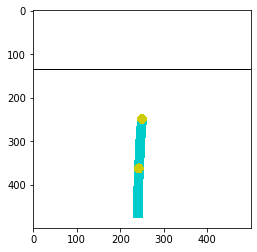

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render('rgb_array'))

In [0]:
import torch.nn.functional as F

class TRPOAgent(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size=32):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple: 
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        nn.Module.__init__(self)

        #<your network here >
        self.layer1 = nn.Linear(state_shape[0], 300)
        self.layer2 = nn.Linear(300, n_actions)
        #self.model = torch.log(nn.Sequential(self.layer1, nn.ReLU(),self.layer2))

    def forward(self, states):
        """
        takes agent's observation (Variable), returns log-probabilities (Variable)
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """

        # Use your network to compute log_probs for given state
        
        log_probs = torch.log(F.softmax(self.layer2(F.relu(self.layer1(states)))))
        return log_probs

    def get_log_probs(self, states):
        '''
        Log-probs for training
        '''

        return self.forward(states)

    def get_probs(self, states):
        '''
        Probs for interaction
        '''

        return torch.exp(self.forward(states))

    def act(self, obs, sample=True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        probs = self.get_probs(Variable(torch.FloatTensor([obs]))).data.numpy()

        if sample:
            action = int(np.random.choice(n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]


agent = TRPOAgent(observation_shape, n_actions)

In [36]:
observation_shape

(6,)

In [37]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(Variable(torch.FloatTensor([env.reset()])))
assert isinstance(
    log_probs, Variable) and log_probs.requires_grad, "qvalues must be a torch variable with grad"
assert len(
    log_probs.shape) == 2 and log_probs.shape[0] == 1 and log_probs.shape[1] == n_actions
sums = torch.sum(torch.exp(log_probs), dim=1)
assert (0.999 < sums).all() and (1.001 > sums).all()

# Demo use
print("sampled:", [agent.act(env.reset()) for _ in range(5)])
print("greedy:", [agent.act(env.reset(), sample=False) for _ in range(5)])

sampled: [(0, array([0.30442736, 0.37006506, 0.32550758], dtype=float32)), (1, array([0.30849797, 0.36672613, 0.3247759 ], dtype=float32)), (2, array([0.31483662, 0.368664  , 0.31649935], dtype=float32)), (1, array([0.310031  , 0.3714923 , 0.31847668], dtype=float32)), (2, array([0.31357569, 0.3681808 , 0.31824353], dtype=float32))]
greedy: [(1, array([0.30903867, 0.37120444, 0.3197569 ], dtype=float32)), (1, array([0.313145  , 0.37245432, 0.31440073], dtype=float32)), (1, array([0.31278303, 0.37246954, 0.31474733], dtype=float32)), (1, array([0.31253353, 0.365006  , 0.3224605 ], dtype=float32)), (1, array([0.3127772 , 0.37251613, 0.31470668], dtype=float32))]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
